<a href="https://colab.research.google.com/github/TytanMikJas/DeepLearningJourney/blob/main/CIFAR10_Auto_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# calculations
import numpy as np

# model
import torch
import torch.nn as nn
import torch.nn.functional as F

# dataset and transformations
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-31-a680a4fd67af>:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [32]:
# Create a basic transformation for our images
custom_transform = T.Compose([  T.ToTensor(),
                                T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), ])

# download train+test CIFAR10
train_data = torchvision.datasets.CIFAR10(root='cifar10', download=True, train=True,  transform=custom_transform)
test_data  = torchvision.datasets.CIFAR10(root='cifar10', download=True, train=False, transform=custom_transform)

# create DataLoaders for train & test
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=len(test_data))

Files already downloaded and verified
Files already downloaded and verified


In [33]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [34]:
def makeTheEncoder():

    class cifarEncoder(nn.Module):
        def __init__(self):
            super().__init__()

        ### -------------- feature map layers -------------- ###
        # Input & Encoder
            self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1)
            self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1)

        # Latent Layer
            self.latent = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)

        # Decoders
            self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
            self.dec_conv2 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)

        # Output
            self.output = nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1)

        def forward(self, x):
            # first and second encoder: convolution -> avgpool -> leakyReLU
            x = (self.enc_conv1(x))
            x = F.leaky_relu(x)
            x = (self.enc_conv2(x))
            x = F.leaky_relu(x)

            # latent layer: convolution -> avgpool -> leakyrelu
            x = (self.latent(x))
            x = F.leaky_relu(x)

            # first and second decoder: convolution -> leakyReLU
            x = self.dec_conv1(x)
            x = F.leaky_relu(x)
            x = self.dec_conv2(x)
            x = F.leaky_relu(x)

            # output
            x = self.output(x)

            return x

    # create the model instance
    net = cifarEncoder()

    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=1e-5)

    return net, lossfun, optimizer

In [35]:
# a function that trains the model

def function2trainTheModel():

    # number of epochs
    numepochs = 20

    # create a new model
    net, lossfun, optimizer = makeTheEncoder()
    net.to(device)

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        batchLoss = []
        for X, y in train_loader:

            X = X.to(device)

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, X)
            batchLoss.append(loss.item())

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # calculate the loss of current epoch
        trainLoss[epochi] = np.mean(batchLoss)

        # extract test data and labels
        X, y = next(iter(test_loader))

        # push data to GPU
        X = X.to(device)

        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
            loss = lossfun(yHat, X)

        # get loss and accuracy rate from the dev batch
        testLoss[epochi] = loss.item()

    # end epochs

    # function output
    return trainLoss, testLoss, net

In [36]:
trainLoss, testLoss, net = function2trainTheModel()

Text(0.5, 1.0, 'Model loss')

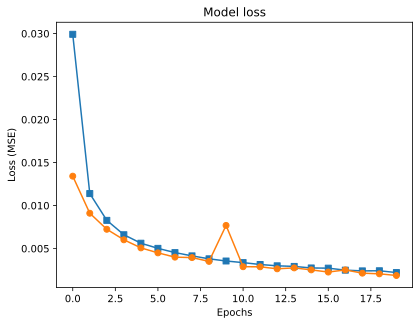

In [37]:
plt.plot(trainLoss,'s-',label='Train')
plt.plot(testLoss,'o-',label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss')

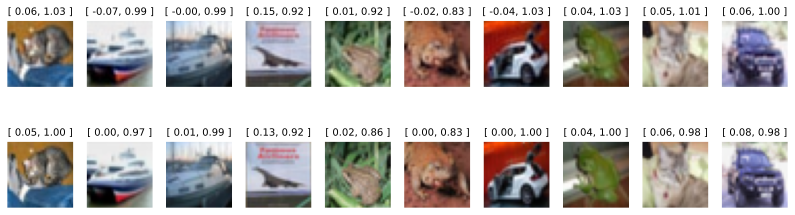

In [38]:
## show some random examples

# get some data
X,y = next(iter(test_loader))

# forward pass and loss
net.cpu()
net.eval() # switch to test mode
yHat = net(X)


fig,axs = plt.subplots(2,10,figsize=(14,4))

for i in range(10):
  pic = yHat[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[0,i].imshow(pic)
  axs[0,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[0,i].axis('off')

  pic = X[i,:,:,:].detach().numpy().transpose((1,2,0))
  pic = pic/2 + .5 # undo normalization
  axs[1,i].imshow(pic)
  axs[1,i].set_title(f'[ {np.min(pic):.2f}, {np.max(pic):.2f} ]',fontsize=10)
  axs[1,i].axis('off')


plt.show()